In [7]:
from pathlib import Path


EVENTS = Path('../data/raw/e2vid/popping_water_balloon.txt')

In [8]:
import numpy as np
import pandas as pd
events = pd.read_csv(EVENTS, sep=" ", header=None, skiprows=[0], names = ["timestamp", "x", "y", "polarity"], dtype={'a': np.float64, 'x': np.int64, 'y': np.int64, 'polarity': np.int64})
events.timestamp -= events.timestamp[0]
events.polarity = events.polarity > 0

In [9]:
import numpy as np


bin_size = 0.02

number_of_temporal_bins = int(np.ceil((events.timestamp.max() / bin_size)))
max_t = number_of_temporal_bins * bin_size

In [10]:
from dynamic_fusion.data_generator.event_discretizer import EventDiscretizer
from dynamic_fusion.data_generator.configuration import EventDiscretizerConfiguration

config = EventDiscretizerConfiguration(number_of_temporal_bins=number_of_temporal_bins, number_of_temporal_sub_bins_per_bin=1)

discretizer = EventDiscretizer(config, max_timestamp=max_t)
size = (events.x.max() + 1, events.y.max() + 1 )

discretized_events = discretizer.run({1: events}, (size[1], size[0]))
discretized_events = discretized_events[1]

(array([1204390., 1265122., 1213988., 1210140., 1175666., 1684187.,
        1026196.,  805030., 1139428., 1025853.]),
 array([0.    , 0.2408, 0.4816, 0.7224, 0.9632, 1.204 , 1.4448, 1.6856,
        1.9264, 2.1672, 2.408 ]),
 <BarContainer object of 10 artists>)

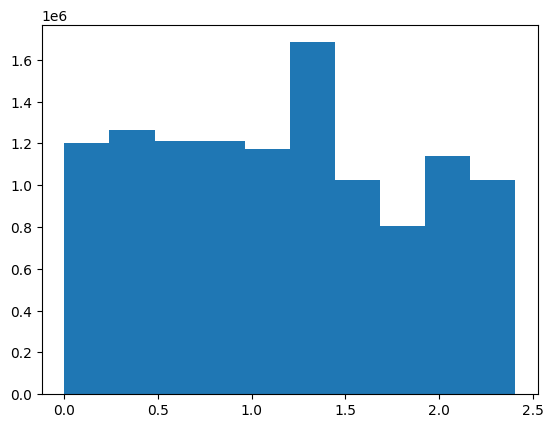

In [11]:
from matplotlib import pyplot as plt
plt.hist(events.timestamp)

In [12]:
len(events) / events.timestamp.max() / (events.x.max() + 1) / (events.y.max() + 1)

15.8840107627356

In [13]:
from matplotlib import pyplot as plt
import numpy as np

from dynamic_fusion.utils.network import to_numpy
from dynamic_fusion.utils.visualization import create_red_blue_cmap, img_to_colormap
import cv2


out = cv2.VideoWriter("real_water.mp4", cv2.VideoWriter.fourcc(*"mp4v"), 10, size)

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (255, 255, 255)  # White color
line_type = 2
position = (10, 50)  # Position of the text (bottom left corner)


for i, eps in enumerate(discretized_events.event_polarity_sum):
    colored_event_polarity_sum = img_to_colormap(to_numpy(eps.sum(dim=0)), create_red_blue_cmap(501))

    evr = discretized_events.event_count[i].sum(dim=0).mean() * number_of_temporal_bins / max_t

    frame_processed = (colored_event_polarity_sum[::-1] * 255).astype(np.uint8)


    cv2.putText(frame_processed, f"Events per second per pixel={evr:.2f}", position, font, font_scale, font_color, line_type)

    out.write(frame_processed)
out.release()
